### Mode Training
Python notebook to load and transform data (using data_transformation.py), model training and testing, loading and predicting on testing data.

In [62]:
# import libraries
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import data_transformation #custom python file for data preprocessing and transformation
warnings.filterwarnings("ignore")

In [ ]:
# Directory path
directory = r'C:\Priyanka\job_application_2024\JPMorganChase\Take Home Project'

In [ ]:
#read the testing data
test_data = pd.read_csv(os.path.join(directory, 'testing_loan_data.csv'))
test_data.head(5)


,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,20000001,22419852,10000,36 months,22.15%,8 years,RENT,37000.0,NaN,debt_consolidation,...,1,3.0,73.10%,16200,NaN,14877.170280,36809,1,131,NaN
1,20000002,22349118,1400,36 months,18.24%,6 years,RENT,41000.0,NaN,other,...,0,9.0,11.50%,4000,NaN,4097.304770,19536,1,19,NaN
2,20000003,22398818,7000,36 months,12.49%,3 years,RENT,68900.0,NaN,debt_consolidation,...,0,11.0,48.10%,11900,80.0,12688.495160,241465,1,92,NaN
3,20000004,22419015,18000,60 months,16.29%,9 years,MORTGAGE,41000.0,NaN,debt_consolidation,...,1,0.0,38.10%,7600,73.0,7908.799817,179757,1,235,NaN
4,20000005,22388614,12000,36 months,12.99%,10+ years,MORTGAGE,64000.0,NaN,home_improvement,...,0,NaN,57.90%,21000,NaN,19378.561060,31953,1,157,NaN


In [ ]:
# read the training data
data = pd.read_csv(os.path.join(directory, 'training_loan_data.csv'), header=1)
data.head(5)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,...,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,...,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,...,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,...,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233.0,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,...,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


### Data Preparation
- remove duplicates based on analysis in data_analysis file
- split data into train and test set

In [4]:
data.drop_duplicates(keep='first', inplace=True)
data.reset_index(drop=True, inplace=True)
data.dropna(subset=['bad_flag'], inplace=True)

In [5]:
len(data)

188123

In [5]:
# split into train and test set
## Separating Independent and Dependent Columns
X = data.drop(['bad_flag'],axis=1)
Y = data[['bad_flag']]

# Splitting the dataset into the Training and Testing set.
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42, stratify=Y)


### Data Preprocessing and Transformation
- Remove the unnecessary features based on EDA.
- feature engineering: convert int_rate, revol_util, emp_length into numerical 
- For categorical features:
    - combine less frequent categories into 'other'
    - impute missing values using Simple Imputer with 'most_frequent' strategy
    - Perform label encoding for emp_length feature to store the order, one hot encoding for rest of the categorical features
- For numerical features:
    - Impute missing values using Simple Imputer with 'median' strategy
    - power tranformation to handle skewed data using 'yeo-johnson' method
    - scaling using Robust scalar since it handles outlier as well

In [6]:
# Performs preprocessing steps on training, validation (x_test) and testing dataset (test_dataset)
x_train = data_transformation.preprocessor(x_train)
x_test = data_transformation.preprocessor(x_test)
test_dataset = data_transformation.preprocessor(test_data)


In [7]:
# Performs data transfomation steps on training, validation (x_test) and testing dataset (test_dataset) to prepare for the model training
x_train, x_test, test_dataset = data_transformation.data_transformation(x_train, x_test, test_dataset)

In [8]:
x_train.head(5)

,loan_amnt,int_rate,annual_inc,percent_bc_gt_75,dti,inq_last_6mths,mths_since_recent_inq,total_bc_limit,tot_cur_bal,tot_hi_cred_lim,emp_length_yr,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_other,term_ 36 months,term_ 60 months
132105,-0.744250,0.497295,-1.036162,0.878352,0.871195,1.000000,0.000000,-0.569646,-1.004436,-0.619818,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
129269,-0.186837,-0.502705,0.225379,0.000000,0.146847,1.541472,-0.168957,1.424469,-0.381477,1.388520,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
29902,-0.288750,-0.182136,0.071567,-0.346551,-0.230385,1.000000,-0.358675,-0.256438,0.376650,-0.250905,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
94628,-0.181905,0.038985,-0.049851,-0.537205,-0.590745,1.000000,-1.641363,-0.364447,-0.871290,-0.366942,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
179406,-1.296275,-1.119014,-0.539874,0.313824,0.450887,0.000000,0.544429,0.615194,0.000000,0.609542,8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [10]:
test_dataset.head(5)

,loan_amnt,int_rate,annual_inc,percent_bc_gt_75,dti,inq_last_6mths,mths_since_recent_inq,total_bc_limit,tot_cur_bal,tot_hi_cred_lim,emp_length_yr,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_other,term_ 36 months,term_ 60 months
0,-0.186837,1.194210,-0.803111,0.547422,0.979636,1.0,-0.576785,0.091363,-0.422867,0.016518,9,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-1.531172,0.641545,-0.640255,-1.333680,0.825399,0.0,0.423215,-0.925480,-0.726601,-0.909975,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.515171,-0.266915,0.159378,0.191038,-0.983831,0.0,0.658250,-0.171443,0.684826,-0.118333,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.467791,0.348238,-0.640255,-0.346551,0.331823,1.0,-1.641363,-0.512060,0.488130,-0.482624,10,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.000000,-0.182136,0.048121,0.461045,0.665450,0.0,0.000000,0.332373,-0.493409,0.255411,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [5]:
'''
My intial plan was to create data processing pipeline using sklearn.pipeline and store it in pickle file for /validationtesting dataset. But, the data was not properly transformed
and I ran out of time, hence I went to above naive approach where I am doing fit_transform on training set and transform on validation and testing set at same time
to avoid data leakage problem. This would have been simpler and clearer with sklearn pipeline. I have kept the commented code in data_transformation.py file in case someone wants to refer it.
'''
'''
import pickle
x_train = data_transformation.preprocessor(x_train)
x_test = data_transformation.preprocessor(x_test)

pipeline = data_transformation.init_pipeline()
pipeline.fit_transform(x_train)
pipeline.transform(x_test)
with open('model_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
'''

### Apply oversampling technique - SMOTE to balance the training set. 
Dataset contains 7% positive class and 93% negatvie class

In [11]:
smote=SMOTE(sampling_strategy='auto', random_state=42)
x_sm , y_sm = smote.fit_resample(x_train,y_train)

In [12]:
print("After Oversampling - SMOTE, the shape of x_train: {}".format(x_sm.shape))
print("After Oversampling - SMOTE, the shape of y_train: {} \n".format(y_sm.shape))

After Oversampling - SMOTE, the shape of x_train: (279992, 20)
After Oversampling - SMOTE, the shape of y_train: (279992, 1) 



### Model Training

The problem is to predict whether the loan will defualt or not i.e. bad_loan = 1 or 0. 
Since the data is highly imbalanced, it is not good idea to only evaluate accuracy. Accuracy is true_predicted/total, so e.g. if model is predicting class 0 correctly 90% of the time, it will not give correct picture of how well the model is predicting positive class. 

Hence we will evalute Precision and Recall (F1-Score) scores:
Precision is important in this scenario because you want to minimize the number of false positives, i.e., approve only those applicants who are less likely to default. If a false positive (approving a bad loan) occurs, it could lead to a financial loss for the lender.

Recall is also crucial because you want to maximize the detection of all the bad loans (defaults). If a false negative (missing a bad loan applicant) happens, it means you are missing potential defaults, which could also be costly.

F1-Score: The F1-score combines both precision and recall into a single metric by calculating their harmonic mean. It's a good choice when you want to balance both precision and recall and ensure that both false positives and false negatives are minimized.

### Neural Network Architecture: 
- Architecture: 2 hiddle layers and one output layer: 20-(10-10)-1
- Generally, small number of neurons are good for small NN. I tried 8, 10 and 16 for both hidden layers
- Chose Activation function as ReLU for hidden layers and Sigmoid function for output.
- The sigmoid function is used in the output layer. This is standard for binary classification problems because the sigmoid function outputs a value between 0 and 1
- Binary Cross-Entropy Loss (BCELoss): This loss function is commonly used for binary classification tasks. It calculates the difference between the predicted probability (from the output layer) and the true label (0 or 1).
- class_weights = torch.tensor([10.0]). This is especially useful in imbalanced datasets, where one class (e.g., good loans) might dominate.
- Adam Optimizer: The Adam optimizer is chosen here due to its effectiveness in training deep neural networks. It adapts the learning rate for each parameter, making it more efficient and faster than standard stochastic gradient descent (SGD). This optimizer is generally a good choice when starting, as it requires less fine-tuning of the learning rate compared to SGD.

In [ ]:
# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_neurons)  # Hidden layer (20, 10)
        self.hidden2 = nn.Linear(hidden_neurons, hidden_neurons)  # Hidden layer (10, 10)
        self.output = nn.Linear(hidden_neurons, output_size)  # Output layer (10,1)
        self.activation = nn.ReLU()  # Activation function for hidden layer
        self.sigmoid = nn.Sigmoid()  # Activation function for output layer

    def forward(self, x):
        x = self.hidden1(x)  # Pass through first hidden layer
        x = self.activation(x)  # Apply activation function (ReLU) after first hidden layer
        x = self.hidden2(x)  # Pass through second hidden layer
        x = self.activation(x)  # Apply activation function (ReLU) after second hidden layer
        x = self.output(x)  # Pass through output layer
        x = self.sigmoid(x)
        return x

# Training function
def train_model(model, x_train_tensor, y_train_tensor, criterion, optimizer, epochs=20):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        epoch_loss = 0
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(x_train_tensor)  # Forward pass
        loss = criterion(outputs.squeeze(), y_train_tensor.squeeze())  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(x_train_tensor):.4f}")
    

# Inference function
def inference(model, x_test_tensor, y_test_tensor):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        outputs = model(x_test_tensor)  # Forward pass
        val_loss = criterion(outputs.squeeze(), y_test_tensor.squeeze())
        print(f"Value Loss: {val_loss.item()}")
        predicted = (outputs.squeeze() > 0.5).float()  # Binary classification threshold
        predictions.extend(predicted.tolist())
    return predictions

# Example Workflow
if __name__ == "__main__":
    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_sm.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_sm.values, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    print(x_train_tensor)
    # Define model, loss function, and optimizer
    input_size = x_train_tensor.shape[1]
    hidden_neurons = 10  # Configurable hidden layer size
    output_size = 1  # Single output for binary classification

    model = NeuralNetwork(input_size, hidden_neurons, output_size)
    class_weights = torch.tensor([10.0])  # Example weight for minority class (adjust as needed)
    #criterion = nn.BCEWithLogitsLoss(weight=class_weights) # This BCEWithLogitsLoss did not give me better result than BCELoss.
    criterion = nn.BCELoss(weight=class_weights)  # Binary Cross-Entropy Loss
    learning_rate = 0.0001 
    epochs = 50
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate) # This optimizer did not give me better result than Adam.

    # Train the model
    print("Training the model...")
    train_model(model, x_train_tensor, y_train_tensor, criterion, optimizer, epochs=epochs)
    print(summary(model, input_size=(input_size,)))
    # Perform inference
    print("\nPerforming inference on test dataset...")
    
    predictions = inference(model, x_test_tensor, y_test_tensor)

    # Output predictions
    print("Predictions:", len(predictions))

tensor([[-0.7442,  0.4973, -1.0362,  ...,  0.0000,  1.0000,  0.0000],
        [-0.1868, -0.5027,  0.2254,  ...,  0.0000,  1.0000,  0.0000],
        [-0.2888, -0.1821,  0.0716,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [-0.0100,  0.8431, -0.8360,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.9719,  0.6312,  0.1385,  ...,  0.0000,  0.0000,  1.0000],
        [-0.3694,  0.2740, -1.0684,  ...,  0.0000,  1.0000,  0.0000]])
Training the model...
Epoch [1/50], Loss: 0.0000
Epoch [2/50], Loss: 0.0000
Epoch [3/50], Loss: 0.0000
Epoch [4/50], Loss: 0.0000
Epoch [5/50], Loss: 0.0000
Epoch [6/50], Loss: 0.0000
Epoch [7/50], Loss: 0.0000
Epoch [8/50], Loss: 0.0000
Epoch [9/50], Loss: 0.0000
Epoch [10/50], Loss: 0.0000
Epoch [11/50], Loss: 0.0000
Epoch [12/50], Loss: 0.0000
Epoch [13/50], Loss: 0.0000
Epoch [14/50], Loss: 0.0000
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 

### Model Evaluation

In [28]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_and_report(y_pred, y_test_tensor):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    features: independent variables
    target: dependent variable
    threshold: threshold for the prediction
    """
    
    cm = confusion_matrix(y_test_tensor.squeeze(), y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    #Accuracy as per the classification report 
    print("\nClassification Report:\n")
    cr=classification_report(y_test_tensor.squeeze(),y_pred)
    print(cr)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.62      0.75     34999
         1.0       0.10      0.53      0.16      2626

    accuracy                           0.62     37625
   macro avg       0.52      0.58      0.46     37625
weighted avg       0.89      0.62      0.71     37625



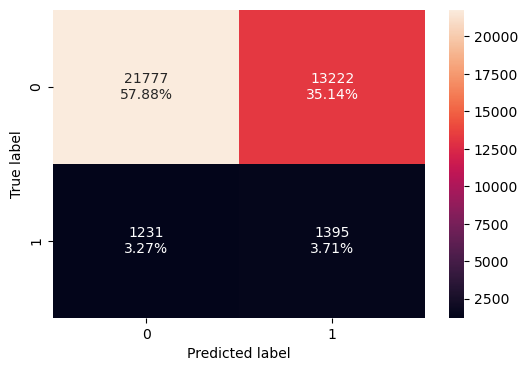

In [51]:
confusion_matrix_and_report(predictions, y_test_tensor)

In [52]:
# Metrics
print("f1_score: {}".format(f1_score(y_test_tensor.squeeze(), predictions)))
print("precision_score: {}".format(precision_score(y_test_tensor.squeeze(), predictions)))
print("recall_score: {}".format(recall_score(y_test_tensor.squeeze(), predictions)))

f1_score: 0.16180479034970713
precision_score: 0.09543682014093179
recall_score: 0.5312261995430312


### Metrics Analysis:
- Precision: Precision is low, meaning that many of the positive predictions made by the model are actually false positives. This implies that the model is overly confident about predicting the bad loans (defaults), but many of those predictions are wrong.

- Recall: Recall is higher, meaning the model is doing a good job of identifying actual bad loans. However, with low precision, many of these "identified" bad loans are false positives.

- F1-Score: The F1-score combines precision and recall, and since precision is so low, the F1-score is significantly impacted. The low F1-score suggests that the model’s overall performance is poor and needs improvement.

- To improve the performance I tried:
    - different multiple hidden layers: 1 and 2
    - epochs: ranging from 20 to 50, 
    - learnign rate: 0.01, 0.001, 0.001
    - class weights: 2, 10, 50, 90
    - different optimizers: ADAM, SGD
    - Trained the model with SMOTE and without SMOTE data
    - threshold tuning: 0.5, 0.6



### Prediction on Testing Dataset

In [66]:
# Save Model for future purpose
torch.save(model.state_dict(),'model_full.pth')

In [67]:
''' This code is call the pipeline for data transformation on testing data'''
'''
# Load the pipeline from the file
with open('model_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)
test_dataset = data_transformation.preprocessor(test_data)
test_dataset = pipeline.transform(test_dataset)
'''

"\n# Load the pipeline from the file\nwith open('model_pipeline.pkl', 'rb') as f:\n    pipeline = pickle.load(f)\ntest_dataset = data_transformation.preprocessor(test_data)\ntest_dataset = pipeline.transform(test_dataset)\n"

In [68]:
# Converting test dataset into pytorch tensors for predictions
test_dataset_tensor = torch.tensor(test_dataset.values, dtype=torch.float32)

In [69]:
# Load the model for prediction.
model.load_state_dict(torch.load('model_full.pth'))

<All keys matched successfully>

In [70]:
# Make prediction using the loaded model
model.eval()  # Set model to evaluation mode
predictions = []
with torch.no_grad():
    outputs = model(test_dataset_tensor)  # Forward pass
    predicted = (outputs.squeeze() > 0.5).float()  # Binary classification threshold
    predictions.extend(predicted.tolist())
print(predictions[:10])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]


In [71]:
# Save predictions into bad_flag column
test_data['bad_flag']=predictions

In [72]:
# Save the file
test_data.to_csv(os.path.join(directory, 'testing_loan_data_predicted.csv'))